In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

#mcc implementation
from torchmetrics.classification import MultilabelMatthewsCorrCoef

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 48
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/train', transform=transform)
validation_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/val', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/test', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=8)

#validation_set = validation_ds
validation_loader = T.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=8)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=8)

In [3]:
class NewNetwork(nn.Module):
    def __init__(self, num_classes=291):
        super(NewNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(64, 64, kernel_size=1, padding=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(64, 64, kernel_size=3, padding=2),
             nn.Dropout(p=0.5),
            nn.Conv2d(64, 256, kernel_size=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(256, 128, kernel_size=1, padding=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(128, 128, kernel_size=3, padding=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(128, 512, kernel_size=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(512, 256, kernel_size=1, padding=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(256, 256, kernel_size=3, padding=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(256, 1024, kernel_size=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(1024, 512, kernel_size=1, padding=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(512, 512, kernel_size=3, padding=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(512, 2048, kernel_size=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(200 * 32 * 32, 1000), #mettre 128 quand il y a 5 couches
            nn.PReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.PReLU(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [4]:
net = NewNetwork()
net.to(device)

NewNetwork(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (13): Dropout(p=0.5, inplace=False)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (15): Dropout(p=0.5, inplace=False)
    (16): Conv2d(128, 512, kernel_size=(1, 1

In [5]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

test_acc = []

mcc_list = []

lrs = []
steps = []

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 101)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    """
    print("predicted = ",predicted)
    print("labels = ",labels)
    """
    
    #MCC implementation
    """
    metric_mcc = MultilabelMatthewsCorrCoef(num_labels=291)
    metric_mcc(predicted, labels)
    mcc_list.append(metric_mcc)
    """
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % 5 == 0: #ici changer pour la frequence d'affichage
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the validation set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the validation set
    with T.no_grad():
        correct = 0
        total = 0
        validation_running_loss = .0
        for data in validation_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 100: # a changer si besoin d'afficher la matrice de confusion, a mettre à epoch-1
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        validation_running_loss /= len(validation_loader)
        validation_loss.append(validation_running_loss)
        validation_running_acc = correct / total
        validation_acc.append(validation_running_acc)
        
        if epoch % 5 == 0: #ici changer pour la frequence d'affichage
            print('validation Acc.  => {:.3f}%'.format(100 * validation_running_acc), end=' | ')
            print('validation Loss  => {:.5f}'.format(validation_running_loss))

    with torch.no_grad():
        correct_t = 0
        total_t = 0
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
            
            running_acc_t = correct_t / total_t
        test_acc.append(running_acc_t)
    
        if epoch % 5 == 0: #ici changer pour la frequence d'affichage
            print('Accuracy of the network on test images: %d %%' % (100 * correct_t / total_t))

print('Finished Training')

  0%|          | 0/101 [00:00<?, ?it/s]


Epoch: 0
Train Acc. => 1.301% | Train Loss => 5.49055
validation Acc.  => 1.371% | validation Loss  => 5.46689
Accuracy of the network on test images: 1 %

Epoch: 5
Train Acc. => 6.911% | Train Loss => 4.16779
validation Acc.  => 8.242% | validation Loss  => 4.03435
Accuracy of the network on test images: 7 %

Epoch: 10
Train Acc. => 19.283% | Train Loss => 3.20681
validation Acc.  => 19.871% | validation Loss  => 3.15101
Accuracy of the network on test images: 20 %

Epoch: 15
Train Acc. => 31.758% | Train Loss => 2.53623
validation Acc.  => 30.435% | validation Loss  => 2.64354
Accuracy of the network on test images: 31 %

Epoch: 20
Train Acc. => 39.541% | Train Loss => 2.17146
validation Acc.  => 39.774% | validation Loss  => 2.18417
Accuracy of the network on test images: 39 %

Epoch: 25
Train Acc. => 45.014% | Train Loss => 1.92309
validation Acc.  => 41.935% | validation Loss  => 2.11251
Accuracy of the network on test images: 41 %

Epoch: 30
Train Acc. => 49.318% | Train Loss =>

## Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

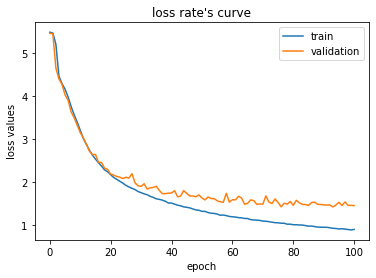

In [8]:
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

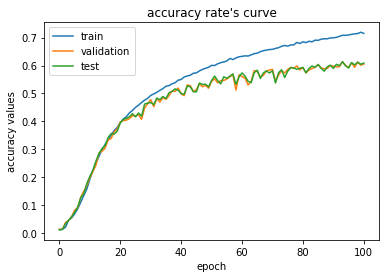

In [9]:
plt.plot(train_acc, label='train')
plt.plot(validation_acc, label='validation')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [10]:
#plt.plot(mcc_list, label='MCC')
#plt.xlabel("epoch")
#plt.ylabel("MCC values")
#plt.title("MCC curve")
#plt.legend()
#plt.show()

In [11]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[12  3  0 ...  0  0  0]
 [ 3 37  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  1 ...  0  0 21]]


<AxesSubplot:>

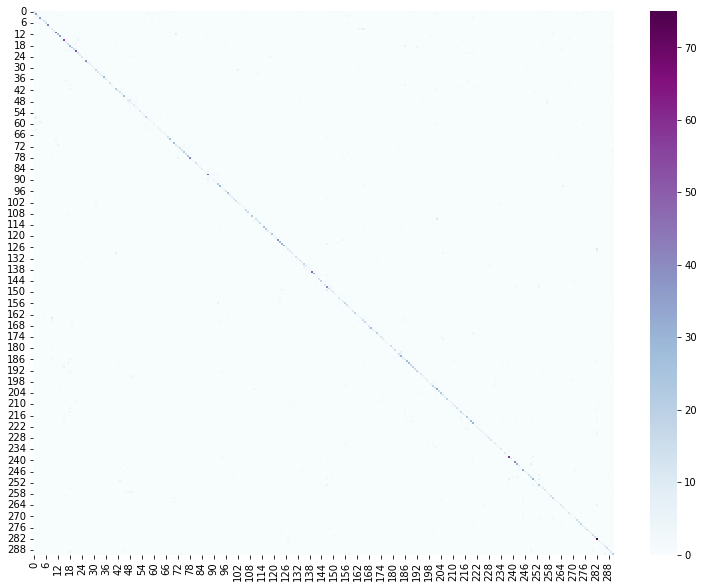

In [12]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [13]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 60.          62.71186441  37.5         64.9122807   50.
  63.15789474  63.63636364  91.4893617   80.          28.94736842
  80.          94.11764706  57.44680851  64.28571429  44.44444444
  63.95348837  63.63636364  61.53846154  56.60377358  52.27272727
  61.53846154  77.94117647  45.16129032  90.          45.83333333
  28.57142857  82.9787234   85.71428571  42.85714286  66.66666667
  83.33333333  47.05882353  45.83333333  63.63636364 100.
  77.77777778  53.33333333   8.33333333  81.25        33.33333333
   9.09090909  61.11111111  77.77777778  87.5         64.28571429
  70.          33.33333333  32.14285714  30.43478261  50.
  81.81818182  50.          25.         100.         100.
  54.54545455  54.54545455  32.          45.45454545   6.66666667
  29.41176471  40.          54.54545455  31.81818182  35.71428571
  55.55555556  66.66666667  38.23529412  81.81818182  33.33333333
  80.          55.          60.          58.33333333  61.9047619
  82.14285714  54.16666667  62.5         67

## Save

In [14]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/dict_Linh_network_1st_try")

In [15]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/Linh_network_entire_model_1st_try")

In [16]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [17]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"